# Regression Model Evaluation
### March 2016

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.svm import SVR, LinearSVR
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest, f_regression

### define functions

In [2]:
def helpFloat(x): 
    try:
        return float ( float(x['thumbsup']) / (float(x['thumbsup']) + float(x['thumbsdown'])) )
    except:
        return 0

def simple_spearman(x,y): return spearmanr(x,y)[0]
spearmanr_scorer = make_scorer(simple_spearman)

### load buscape reviews

In [4]:
reviews_features = pd.read_csv('reviews.csv.gz', compression='gzip')
reviews_columns = reviews_features.select_dtypes(include=['float64','int']).columns
reviews_features['helpfulness'] = reviews_features.apply(helpFloat,axis=1)
reviews_features.shape

(32226, 48)

### select a category

In [5]:
reviews_features = reviews_features[reviews_features.category == 'TV']
reviews_features = reviews_features[reviews_features.helpfulness != 0]
#reviews_features.to_csv('reviews-help.csv')
reviews_features.shape

(4567, 48)

### split data and class

In [6]:
# split class and features
labels = reviews_features["helpfulness"].values
del reviews_features['helpfulness']
features = reviews_features[list(reviews_columns)].values

# clean features
features = np.abs(features)
features[np.isnan(features) == True] = 0

features.shape

(4567, 34)

## 1. Run 10-fold cross validation over N kbest features

###  1.1. for linear regression

In [7]:
linear_model = LinearSVR(epsilon=0.01)

n_features_linear = []
spearmanr_scores_linear = []

for i in range(1, 16):
    n_features_linear.append(i)
    
    kbest_features = SelectKBest(f_regression, k=i).fit_transform(features, labels)
    scores = cross_val_score(linear_model, kbest_features, labels, cv=10, scoring=spearmanr_scorer)
    spearmanr_scores_linear.append(scores.mean())
    
    print i

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


###  1.2. for rbf regression

In [8]:
svr_model = SVR(C=1.0, epsilon=0.01, kernel='rbf')

n_features_svr = []
spearmanr_scores_svr = []

for i in range(1, 16):
    n_features_svr.append(i)
    
    kbest_features = SelectKBest(f_regression, k=i).fit_transform(features, labels)
    scores = cross_val_score(svr_model, kbest_features, labels, cv=10, scoring=spearmanr_scorer)
    spearmanr_scores_svr.append(scores.mean())
    
    print i

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


### 1.3 Plot Chart

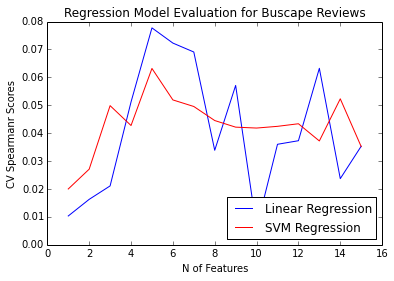

In [9]:
plt.figure()

plt.plot(n_features_linear, spearmanr_scores_linear, 'b', label='Linear Regression')
plt.plot(n_features_svr, spearmanr_scores_svr, 'r', label='SVM Regression')

plt.xlabel('N of Features')
plt.ylabel('CV Spearmanr Scores')
plt.legend(loc='lower right')
plt.title('Regression Model Evaluation for Buscape Reviews')

plt.show()